In [1]:
from spatialSSL.Dataloader import FullImageDatasetConstructor
from spatialSSL.Utils import split_dataset,visualize_cell_type_accuracies
from spatialSSL.Training import train,train_classification,test_classification
from spatialSSL.Models import GAT4,Transferlearn
from spatialSSL.Training import train_epoch
from spatialSSL.Testing import test
from spatialSSL.Dataset import InMemoryGraphDataset
import torch.nn as nn
import numpy as np

/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic

In [2]:
# Fine tune
import torch
import zipfile

# Define a function to load the data from the ZIP file
def load_from_zip(zip_path, file_name):
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        with zipf.open(file_name) as file:
            return torch.load(file)

# Load the pre_val_list for fine tuning
pre_val_list = load_from_zip('./processed_data/pre_training_data_img6_r30_n1_random_01.zip', 'pre_val_list.pt')
pre_train_list = load_from_zip('./processed_data/pre_training_data_img6_r30_n1_random_01.zip', 'pre_train_list.pt')

In [3]:
pre_val_list

[Data(
   x=[26230, 550],
   edge_index=[2, 234482],
   edge_attr=[26230, 26230],
   cell_mask_index=[2623],
   cell_type=[26230],
   image='1199650929',
   num_nodes=26230,
   encode_book={
     Astro-Epen=0,
     CB GABA=1,
     CB Glut=2,
     CNU GABA=3,
     CNU-HYa GABA=4,
     CNU-HYa Glut=5,
     HY GABA=6,
     HY Glut=7,
     HY Gnrh1 Glut=8,
     Immune=9,
     LQ=10,
     MB Dopa=11,
     MB GABA=12,
     MB Glut=13,
     MB-HB Sero=14,
     MOB-DG-IMN=15,
     MY GABA=16,
     MY Glut=17,
     OEG=18,
     Oligo=19,
     P GABA=20,
     P Glut=21,
     TH Glut=22,
     Vascular=23
   }
 ),
 Data(
   x=[29300, 550],
   edge_index=[2, 259136],
   edge_attr=[29300, 29300],
   cell_mask_index=[2930],
   cell_type=[29300],
   image='1199650932',
   num_nodes=29300,
   encode_book={
     Astro-Epen=0,
     CB GABA=1,
     CB Glut=2,
     CNU GABA=3,
     CNU-HYa GABA=4,
     CNU-HYa Glut=5,
     HY GABA=6,
     HY Glut=7,
     HY Gnrh1 Glut=8,
     Immune=9,
     LQ=10,
     MB 

In [4]:
len(pre_train_list)

4

In [5]:
from sklearn.model_selection import train_test_split

###################### Now for testing
# Split the pre_val_list into 80% for tune_train and 20% for temporary validation/test
tune_train, temp_val_test = train_test_split(pre_train_list, test_size=0.20, random_state=42)

# Split the temporary validation/test into 50% for tune_val and 50% for tune_test
tune_val, tune_test = train_test_split(pre_val_list, test_size=0.50, random_state=42)

# Now, tune_train contains 80% of pre_val_list, tune_val contains 10%, and tune_test contains 10%

In [6]:
# Load into dataloader 

from torch_geometric.loader import DataLoader

# Create DataLoader objects for pre-training and pre-validation
tune_train_loader = DataLoader(tune_train, batch_size=1, shuffle=True)
tune_val_loader = DataLoader(tune_val, batch_size=1, shuffle=False)
tune_test_loader = DataLoader(tune_test, batch_size=1, shuffle=False)
# Now you can use pre_train_loader and pre_val_loader in your training loop


In [7]:
# Load pre-trained models

PRE_TRAINED_MODEL_PATH = "./models/img6_r30_n1_random_01_GAT4_0.001_weight.pt"


# Create Identity class
class Identity(nn.Module):
    def __init__(self):
        super(Identity,self).__init__()
        
    def forward(self,x):
        return x





In [8]:
# Load pre-trained model and add our layers


in_channels  = 550
hidden_channels_1 = 256
hidden_channels_2 = 33
out_channels= 550

# Pretraining
# Define the device
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') #"cpu"

def freeze_except_last(model, num_unfrozen_layers=1):
    # Convert model parameters into a list
    params = list(model.parameters())

    # Freeze all parameters
    for param in params:
        param.requires_grad = False

    # Unfreeze the last 'num_unfrozen_layers' layers
    for param in params[-num_unfrozen_layers:]:
        param.requires_grad = True

model = GAT4(in_channels, hidden_channels_1,hidden_channels_2, out_channels).to(device)

model.load_state_dict(torch.load(PRE_TRAINED_MODEL_PATH))
freeze_except_last(model, num_unfrozen_layers=1) # Unfreeze the last 2 layers

# Training code
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
criterion = nn.MSELoss()



In [9]:
# transfer learning
import torch

num_classes = 33
in_channels  = 550
hidden_channels_1 = 256
hidden_channels_2 = 33
out_channels= 550

freeze = True
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') #"cpu"
pretrained_model = GAT4(in_channels, hidden_channels_1,hidden_channels_2, out_channels)

if freeze:
    for param in pretrained_model.parameters():
        param.requires_grad = False

model = Transferlearn(pretrained_model,out_channels,hidden_channels_1,num_classes).to(device)
model








Transferlearn(
  (pre_trained_model): GAT4(
    (conv1): GATConv(550, 256, heads=1)
    (conv2): GATConv(256, 33, heads=1)
    (conv3): GATConv(33, 256, heads=1)
    (conv4): GATConv(256, 550, heads=1)
    (dropout): Dropout(p=0.2, inplace=False)
    (act): LeakyReLU(negative_slope=0.01)
  )
  (buffer): Linear(in_features=550, out_features=256, bias=True)
  (classifier): Linear(in_features=256, out_features=33, bias=True)
  (act): LeakyReLU(negative_slope=0.01)
)

In [10]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_classification(model=model, train_loader=tune_train_loader, val_loader=tune_val_loader, num_epochs=10,criterion=criterion, num_classes=num_classes,optimizer=optimizer)

Epoch 1/10, train loss: 3.4073, train accuracy: 0.1601, train auprc: 0.0402, val loss: 3.1874, val accuracy: 0.3759, val auprc: 0.3759, Time: 1.0140s
Epoch 2/10, train loss: 3.0726, train accuracy: 0.2679, train auprc: 0.0375, val loss: 2.7868, val accuracy: 0.3751, val auprc: 0.3751, Time: 0.4262s
Epoch 3/10, train loss: 2.6707, train accuracy: 0.3114, train auprc: 0.0359, val loss: 2.3650, val accuracy: 0.3753, val auprc: 0.3753, Time: 0.4486s
Epoch 4/10, train loss: 2.2822, train accuracy: 0.3331, train auprc: 0.0353, val loss: 2.0553, val accuracy: 0.3755, val auprc: 0.3755, Time: 0.8745s
Epoch 5/10, train loss: 2.0194, train accuracy: 0.3469, train auprc: 0.0349, val loss: 1.8930, val accuracy: 0.3823, val auprc: 0.3823, Time: 0.4021s
Epoch 6/10, train loss: 1.8843, train accuracy: 0.3575, train auprc: 0.0347, val loss: 1.8105, val accuracy: 0.3934, val auprc: 0.3934, Time: 0.4233s
Epoch 7/10, train loss: 1.8094, train accuracy: 0.3673, train auprc: 0.0349, val loss: 1.7331, val a

Test loss: 1.5520, Test accuracy: 0.5239, Test auprc: 0.0591


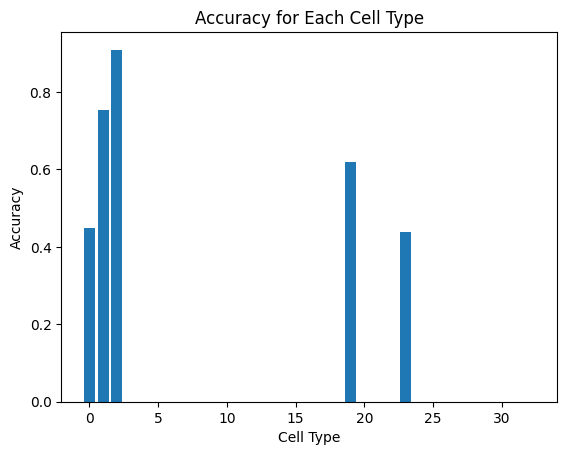

In [11]:
from sklearn.metrics import accuracy_score
cell_type_accuracies = test_classification(model, tune_test_loader, criterion, num_classes)
visualize_cell_type_accuracies(cell_type_accuracies)

In [24]:

# Define loss function and optimizer
#criterion = nn.MSELoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 300
patience = 8

In [25]:
train(model=model, train_loader=tune_train_loader, val_loader=tune_val_loader, criterion=criterion, num_epochs= num_epochs, patience = patience, optimizer= optimizer,weight_loss = False ,model_path = './models/img6_r30_n1_random_01_GAT4_0.001_tuned_r30_n1_random_01_freeze_1_GAT4_0.001.pt')


Epoch 1/300, train loss: 0.4793, train r2: 0.0945, train mse: 0.4787,  val loss: 0.5247, val r2: 0.0874, val mse: 0.5247, Time: 1.4150s
Epoch 2/300, train loss: 0.4763, train r2: 0.0978, train mse: 0.4772,  val loss: 0.5240, val r2: 0.0889, val mse: 0.5244, Time: 0.8651s
Epoch 3/300, train loss: 0.4738, train r2: 0.1032, train mse: 0.4758,  val loss: 0.5229, val r2: 0.0875, val mse: 0.5239, Time: 0.8251s
Epoch 4/300, train loss: 0.4726, train r2: 0.1061, train mse: 0.4749,  val loss: 0.5224, val r2: 0.0897, val mse: 0.5235, Time: 0.8236s
Epoch 5/300, train loss: 0.4718, train r2: 0.1087, train mse: 0.4741,  val loss: 0.5217, val r2: 0.0911, val mse: 0.5231, Time: 0.8551s
Epoch 6/300, train loss: 0.4708, train r2: 0.1110, train mse: 0.4735,  val loss: 0.5210, val r2: 0.0924, val mse: 0.5228, Time: 0.8620s
Epoch 7/300, train loss: 0.4704, train r2: 0.1129, train mse: 0.4729,  val loss: 0.5200, val r2: 0.0936, val mse: 0.5224, Time: 0.8434s
Epoch 8/300, train loss: 0.4700, train r2: 0.114

KeyboardInterrupt: 

In [ ]:
pre_trained_model = model.load_state_dict(torch.load(PRE_TRAINED_MODEL_PATH))
